### Chapter 9 problem: making the model using Flopy
see Anderson, Woessner and Hunt (2015), p 432 for a description

requires the ```flopy``` package (https://github.com/modflowpy/flopy)

#### Define general model characteristics

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy

%matplotlib inline

path = 'modelfiles' # folder model and PEST files

#model domain and grid definition
Lx = 1500.
Ly = 1500.
ztop = 600.
zbot = 450.
nlay = 1
nrow = 15
ncol = 15
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

# properties
Khvalues = {1: 44, 2: 5.5} # dictionary of K values by zone number (1 = sand, 2 = silt)
Vani = 1.
sy = 0.1
ss = 1.e-4
laytyp = 1

# global BC settings
m_riv = 2 # riverbed thickness
w_riv = 100 # riverbed width
R = 0.0001 # recharge rate
Qleak = 45000 # flow through southern boundary (pos. = inflow)
Rcond = 150000

# pumping well for transient simulation
QA = -20000
pumping_well_info = [0, 6, 10, QA] # l, r, c, Q zero-based for flopy!

# Stress Periods
nper = 2
perlen = [1, 3]
nstp = [1, 10]
tsmult = [1, 2]
steady = [True, False]

In [26]:
# create flopy objects for packages
modelname = 'P9Tcal'
m = flopy.modflow.Modflow(modelname, version='mfnwt', model_ws=path)

In [27]:
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:],
                               nper=nper, perlen=perlen, tsmult=tsmult, nstp=nstp, steady=steady)

In [28]:
# Variables for the BAS package
# Note that changes from the previous tutorial!
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = 515. * np.ones((nlay, nrow, ncol), dtype=np.float32) # starting heads
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

In [29]:
# Output Control
words = ['save head','save drawdown','save budget']
save_head_every = 1

stress_period_data = {(0,0): words}
oc = flopy.modflow.ModflowOc(m, stress_period_data=stress_period_data, compact=True)

In [30]:
# solver
#pcg = flopy.modflow.ModflowPcg(mf, relax=1)
nwt = flopy.modflow.ModflowNwt(m)

In [31]:
# recharge package
rch = flopy.modflow.mfrch.ModflowRch(m, nrchop=3, rech=R, irch=1, extension='rch', unitnumber=19)

#### Make the hydraulic conductivity array (upw package):

In [32]:
# cell numbers with silt
silt = np.append(np.arange(78, 84), np.arange(93, 99))
silt

array([78, 79, 80, 81, 82, 83, 93, 94, 95, 96, 97, 98])

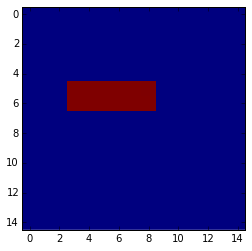

In [33]:
# now creaty Kzones array and assign second zone value to cells with silt
Kzones = np.ones(225) * 1
Kzones[silt] = 2
Kzones = np.reshape(Kzones, (15, 15))

# show the Kzones array
plt.imshow(Kzones, interpolation='none')

# save the Kzones for calibration with PEST
np.savetxt(os.path.join(path,'Kzones.dat'), Kzones, delimiter=' ', fmt='%i')

In [34]:
# assign K values based on zone
hk = np.ones((15, 15), dtype=float) # initialize new array for Kvalues
for z, v in Khvalues.items(): hk[Kzones == z] = v # assign K value corresponding to zone for each value in Kzones array

# make the lpf object
#lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp)
upw = flopy.modflow.ModflowUpw(m, hk=hk, vka=1, sy=sy, ss=ss, laytyp=laytyp)

//anaconda/envs/py34/lib/python3.4/site-packages/flopy/modflow/mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")
//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


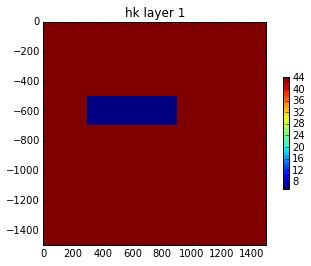

In [35]:
ax = upw.hk.plot(colorbar=True)

#### Now make the river cells:

In [36]:
# bring in river cell information from csv file
rivcells = pd.read_csv('rivercells.csv')
rivcells

,layer,row,column,stage,Rcond,rbot
0,1,1,1,510.0,150000,506.0
1,1,1,2,509.5,150000,505.5
2,1,1,3,509.0,150000,505.0
3,1,1,4,508.5,150000,504.5
4,1,1,5,508.0,150000,504.0
5,1,1,6,507.5,150000,503.5
6,1,1,7,507.0,150000,503.0
7,1,2,8,506.5,150000,502.5
8,1,3,9,506.0,150000,502.0
9,1,3,10,505.5,150000,501.5


In [37]:
# convert indices to zero-based
rivcells[['layer', 'row', 'column']] = rivcells[['layer', 'row', 'column']] -1

# update rCond values with single paramter value from top of script
rivcells['Rcond'] = Rcond

# make dataframe into list for flopy input
rivdata = rivcells.values.tolist()

# need to copy river cell info for each stress period
rivdata = {0: rivdata}
rivdata

{0: [[0.0, 0.0, 0.0, 510.0, 150000.0, 506.0],
  [0.0, 0.0, 1.0, 509.5, 150000.0, 505.5],
  [0.0, 0.0, 2.0, 509.0, 150000.0, 505.0],
  [0.0, 0.0, 3.0, 508.5, 150000.0, 504.5],
  [0.0, 0.0, 4.0, 508.0, 150000.0, 504.0],
  [0.0, 0.0, 5.0, 507.5, 150000.0, 503.5],
  [0.0, 0.0, 6.0, 507.0, 150000.0, 503.0],
  [0.0, 1.0, 7.0, 506.5, 150000.0, 502.5],
  [0.0, 2.0, 8.0, 506.0, 150000.0, 502.0],
  [0.0, 2.0, 9.0, 505.5, 150000.0, 501.5],
  [0.0, 2.0, 10.0, 505.0, 150000.0, 501.0],
  [0.0, 2.0, 11.0, 504.5, 150000.0, 500.5],
  [0.0, 1.0, 12.0, 504.0, 150000.0, 500.0],
  [0.0, 1.0, 13.0, 503.5, 150000.0, 499.5],
  [0.0, 0.0, 14.0, 503.0, 150000.0, 499.0]]}

In [38]:
# make the riv package object
riv = flopy.modflow.mfriv.ModflowRiv(m, ipakcb=59, stress_period_data=rivdata, 
                                     extension='riv', unitnumber=18, options=None, naux=0)

//anaconda/envs/py34/lib/python3.4/site-packages/flopy/modflow/mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")


In [39]:
m.namefile

'P9Tcal.nam'

#### Make the leaking ditch:

In [40]:
# designate flux cells
flux_cells = list(zip(np.ones(15, dtype=int) * 14, np.arange(0, 15)))
flux_cells


[(14, 0),
 (14, 1),
 (14, 2),
 (14, 3),
 (14, 4),
 (14, 5),
 (14, 6),
 (14, 7),
 (14, 8),
 (14, 9),
 (14, 10),
 (14, 11),
 (14, 12),
 (14, 13),
 (14, 14)]

In [41]:
q = Qleak / len(flux_cells) # flow rate in each constant flux cell

In [42]:
# now make list of layer, row, column, q info for each pumping cell, for each stress period
bflux = {0: [[0, c[0], c[1], q] for c in flux_cells]}

# add pumping well to second (transient) stress period
bflux[1] = pumping_well_info

bflux

{0: [[0, 14, 0, 3000.0],
  [0, 14, 1, 3000.0],
  [0, 14, 2, 3000.0],
  [0, 14, 3, 3000.0],
  [0, 14, 4, 3000.0],
  [0, 14, 5, 3000.0],
  [0, 14, 6, 3000.0],
  [0, 14, 7, 3000.0],
  [0, 14, 8, 3000.0],
  [0, 14, 9, 3000.0],
  [0, 14, 10, 3000.0],
  [0, 14, 11, 3000.0],
  [0, 14, 12, 3000.0],
  [0, 14, 13, 3000.0],
  [0, 14, 14, 3000.0]],
 1: [0, 6, 10, -20000]}

In [43]:
# create the well package
wel = flopy.modflow.ModflowWel(m, stress_period_data=bflux)

//anaconda/envs/py34/lib/python3.4/site-packages/flopy/modflow/mfdis.py:164: UserWarning: ModflowDis.sr is deprecated. use Modflow.sr
  warnings.warn("ModflowDis.sr is deprecated. use Modflow.sr")


#### review the packages that have been created

In [44]:
m.get_package_list()

['DIS', 'BAS6', 'OC', 'NWT', 'RCH', 'UPW', 'RIV', 'WEL']

#### check the model input for common errors

In [45]:
m.check()


P9Tcal MODEL DATA VALIDATION SUMMARY:
  2 Warnings:
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    RIV package: stage below cell bottom
    RIV package: rbot below cell bottom
    RIV package: RIV stage below rbots
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    WEL package: BC indices valid
    WEL package: not a number (Nan) entries
    WEL package: BC in inactive cells
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: vertical hydraulic conductivity values below checker threshold of 1e-

#### write input

In [46]:
#write the model input files
m.write_input()

In [47]:
# manually append info for writing out riv package results to nam file (couldn't figure out how to make flopy do this)
nam = open('{}.nam'.format(modelname),'a')
nam.write('DATA(BINARY)  59 {}.rivout REPLACE\n'.format(modelname))
nam.close()



#### Visualize model

//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


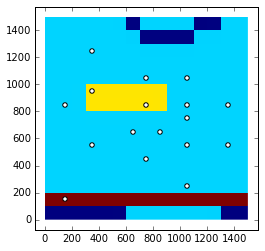

In [48]:
# show the observation locations with the K zones, River cells, and pumping wells
fig = plt.figure()
ax = fig.add_subplot(111)
extent = [0, 1500, 0, 1500]

# add the river cells and wells to the Kzones array so we can verify where they are
for i in range(len(rivcells)):
    Kzones[rivcells.row[i] - 1, rivcells.column[i] - 1] = 0
for w in bflux[0]:
    r, c = w[1:3]
    Kzones[r - 1, c - 1] = 3
ax.imshow(Kzones, extent=extent, interpolation='None')

# bring in observation info
obs = pd.read_csv('observations.csv')
ax.scatter(obs.X, obs.Y, c='w')

#### Run the model
can run manually or using flopy if the executable name is supplied as an argument when creating the MODFLOW object  
e.g. 
```
flopy.modflow.Modflow(m, exe_name='MODFLOW-NWT.ext')
```  
and after creating packages
```
m.run_model()
```
see the **Flopy Notebook examples** https://github.com/modflowpy/flopy/tree/master/examples/Notebooks